# Train Models

This notebook trains the followiing models on multiple trials to test the performance of the models on the dataset.

In [91]:
import pandas as pd
import numpy as np
import re
import os
from matplotlib.colors import hex2color
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense
from sklearn.preprocessing import LabelEncoder

## Reusable functions

In [92]:
def load_dataset(filepath):
    df = pd.read_csv(filepath)

    # Rename columns
    df.rename(columns={"type": "target"}, inplace=True)

    # Rename labels to support binary classification
    df["target"] = df["target"].map(
        lambda x: "malicious" if x != "benign" else "benign"
    )

    return df

In [93]:
def plot_distribution(df, title):
    os.makedirs("./outputs", exist_ok=True)
    
    distribution = dict(df["target"].value_counts())

    # Set up the figure with a white background
    fig, ax = plt.subplots(facecolor='white')

    dull_red = hex2color('#E34234')
    dull_green = hex2color('#32712C')

    # Plotting the pie chart
    ax.pie(distribution.values(), labels=distribution.keys(), colors=[dull_green, dull_red], autopct='%1.1f%%', startangle=90)
    ax.set_title(title)
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

    # Show the pie chart
    plt.show()
    
    # Save the pie chart
    fig.savefig(f"./outputs/{title}.png", bbox_inches='tight')
    
    plt.close(fig)

In [94]:
def tokenize_urls(urls):
    tokenized_urls = []

    for url in urls:
        # Remove sequential strings following '#' and '?'
        url = re.sub(r"#.*", "", url)
        url = re.sub(r"\?.*", "", url)

        # Split the URL into protocol and rest (domain, path and file)
        protocol, rest = url.split("://", 1) if "://" in url else ("", url)

        # Split the rest into domain and rest (path and file)
        domain, rest = rest.split("/", 1) if "/" in rest else (rest, "")

        # Split the rest into path and file
        path, file = rest.rsplit("/", 1) if "/" in rest else (rest, "")

        tokenized_urls.append([protocol, domain, path, file])

    return tokenized_urls

In [95]:
def train_word2vec_model(
    sentences,
    model_path="./models/word2vec.model",
    load_model=False,
    save_model=True,
):
    if load_model:
        return Word2Vec.load(model_path)

    model = Word2Vec(
        sentences,
        vector_size=200,
        window=5,
        min_count=2,
        workers=10,
        sg=1,
        epochs=15,
        negative=10,
    )

    if save_model:
        model.save(model_path)

    return model

In [96]:
def get_url_embeddings(url_setences, model):
    url_embeddings = []

    for tokenized_url in url_setences:
        # Get embeddings for each token in the URL
        embeddings = [model.wv[token] for token in tokenized_url if token in model.wv]

        # If tokens are present in the model vocabulary, compute the mean of the embeddings
        # Else, return a zero vector
        url_embeddings.append(
            np.mean(embeddings, axis=0) if embeddings else np.zeros(model.vector_size)
        )

    return url_embeddings

In [97]:
def train_evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=10000,
):  
    if type(model).__name__ == "Sequential":
        model_name = "CNN"
    elif type(model).__name__ == "RandomForestClassifier":
        model_name = "Random Forest"
    else:
        model_name = "Naive Bayes"
    
    accuracy_list = []

    # Calculate the total number of batches
    total_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size != 0 else 0)

    print(f"Training {model_name} on {total_batches} batches")

    for i in tqdm(range(0, len(X_train), batch_size), total=total_batches, desc="Batches"):

        # Define the batches
        X_train_batch = X_train[i : i + batch_size]
        y_train_batch = y_train[i : i + batch_size]

        # Train model on batch
        if model_name == "Naive Bayes":
            model.partial_fit(X_train_batch, y_train_batch, classes=["benign", "malicious"])
            
        elif model_name == "Random Forest":
            model.n_estimators += 10
            model.fit(X_train_batch, y_train_batch)
        
        elif model_name == "CNN":
            model.fit(X_train_batch, y_train_batch, epochs=1, batch_size=batch_size)

        # Predict on test set
        y_pred = model.predict(X_test)
        if model_name == "CNN":
            y_pred = (y_pred > 0.5).astype(int)

        # Add accuracy to accuracy list
        accuracy_list.append(accuracy_score(y_test, y_pred))

    return model, accuracy_list

In [98]:
def cnn_model():
    # Define the CNN model
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=(200, 1)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [99]:
def run_trial(X_train, y_train, X_test, y_test):
    accuracy_dict = {}
    
    # Train and evaluate models
    for name, model in [
        ("Random Forest", RandomForestClassifier(n_estimators=10, n_jobs=15, warm_start=True)),
        ("Naive Bayes", GaussianNB()),
        ("CNN", cnn_model()),
    ]:
        if name == "CNN":
            label_encoder = LabelEncoder()
            all_labels = np.concatenate((y_train, y_test))
            label_encoder.fit(all_labels)
            
            X_train = np.array(X_train)
            X_test = np.array(X_test)
            y_train = label_encoder.transform(y_train)
            y_test = label_encoder.transform(y_test)
            
        # Train and evaluate model
        trained_model, accuracy_list = train_evaluate_model(
            model, X_train, y_train, X_test, y_test
        )

        # Add accuracy list to accuracy dictionary
        accuracy_dict[name] = { "accuracy_list": accuracy_list }
        
        # Predict on the trained model
        y_pred = trained_model.predict(X_test)
        if name == "CNN":
            y_pred = (y_pred > 0.5).astype(int)

        # Print classification report
        accuracy_dict[name]["report"] = classification_report(y_test, y_pred, digits=4, zero_division=0)

    return accuracy_dict

## Run multiple trials

In [100]:
# Load datasets
trials = [
    # Trial Name, Train Dataset Path, Test Dataset Path
    ("Trial 1 (Baseline)", "./datasets/trial_1/train.csv", "./datasets/trial_1/test.csv"),
    ("Trial 2 (GenTrain_OriTest)", "./datasets/trial_2/train.csv", "./datasets/trial_2/test.csv"),
    ("Trial 3 (MixTrain_OriTest)", "./datasets/trial_3/train.csv", "./datasets/trial_3/test.csv"),
    ("Trial 4 (ReplaceMalicious)", "./datasets/trial_4/train.csv", "./datasets/trial_4/test.csv"),
    ("Trial 5 (ReplaceBenign)", "./datasets/trial_5/train.csv", "./datasets/trial_5/test.csv"),
]

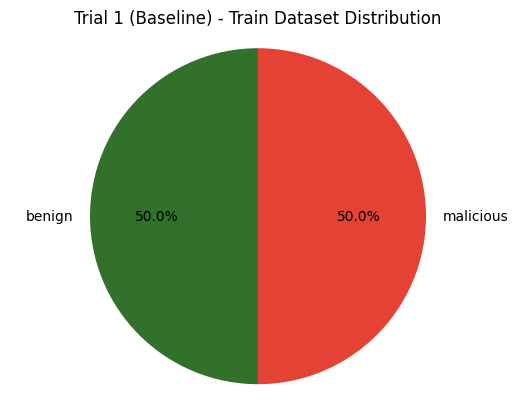

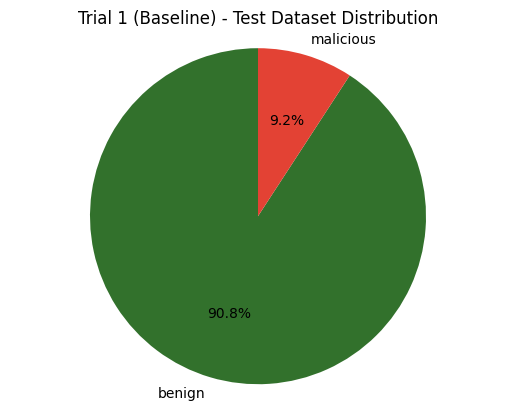

Training Random Forest on 40 batches


Batches: 100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


Training Naive Bayes on 40 batches


Batches: 100%|██████████| 40/40 [01:23<00:00,  2.10s/it]


Training CNN on 40 batches


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

7850/7850 [==============================] - 11s 1ms/step


Batches:   2%|▎         | 1/40 [00:16<10:24, 16.01s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:   5%|▌         | 2/40 [00:31<09:48, 15.48s/it]

7850/7850 [==============================] - 15s 2ms/step


Batches:   8%|▊         | 3/40 [00:51<10:51, 17.61s/it]

7850/7850 [==============================] - 13s 2ms/step


Batches:  10%|█         | 4/40 [01:08<10:33, 17.61s/it]

7850/7850 [==============================] - 13s 2ms/step


Batches:  12%|█▎        | 5/40 [01:25<10:03, 17.25s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  15%|█▌        | 6/40 [01:40<09:17, 16.41s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  18%|█▊        | 7/40 [01:55<08:50, 16.09s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  20%|██        | 8/40 [02:11<08:27, 15.86s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  22%|██▎       | 9/40 [02:26<08:02, 15.58s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  25%|██▌       | 10/40 [02:41<07:42, 15.42s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  28%|██▊       | 11/40 [02:56<07:23, 15.28s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  30%|███       | 12/40 [03:10<07:04, 15.15s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  32%|███▎      | 13/40 [03:26<06:52, 15.27s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  35%|███▌      | 14/40 [03:41<06:35, 15.23s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  38%|███▊      | 15/40 [03:56<06:19, 15.18s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  40%|████      | 16/40 [04:11<06:03, 15.15s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  42%|████▎     | 17/40 [04:26<05:47, 15.10s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  45%|████▌     | 18/40 [04:41<05:31, 15.08s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  48%|████▊     | 19/40 [04:56<05:13, 14.93s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  50%|█████     | 20/40 [05:12<05:05, 15.30s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  52%|█████▎    | 21/40 [05:27<04:49, 15.24s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  55%|█████▌    | 22/40 [05:43<04:35, 15.32s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  57%|█████▊    | 23/40 [05:58<04:19, 15.25s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  60%|██████    | 24/40 [06:13<04:03, 15.20s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  62%|██████▎   | 25/40 [06:28<03:47, 15.16s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  65%|██████▌   | 26/40 [06:43<03:31, 15.09s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  68%|██████▊   | 27/40 [06:58<03:16, 15.14s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  70%|███████   | 28/40 [07:13<03:02, 15.20s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  72%|███████▎  | 29/40 [07:28<02:46, 15.17s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  75%|███████▌  | 30/40 [07:43<02:31, 15.12s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  78%|███████▊  | 31/40 [07:58<02:15, 15.02s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  80%|████████  | 32/40 [08:13<02:00, 15.09s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  82%|████████▎ | 33/40 [08:29<01:45, 15.13s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  85%|████████▌ | 34/40 [08:44<01:30, 15.14s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  88%|████████▊ | 35/40 [08:59<01:16, 15.22s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  90%|█████████ | 36/40 [09:14<01:00, 15.22s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  92%|█████████▎| 37/40 [09:30<00:45, 15.27s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  95%|█████████▌| 38/40 [09:45<00:30, 15.15s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  98%|█████████▊| 39/40 [10:00<00:15, 15.13s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches: 100%|██████████| 40/40 [10:15<00:00, 15.39s/it]

   1/7850 [..............................] - ETA: 5:49

7850/7850 [==============================] - 12s 1ms/step


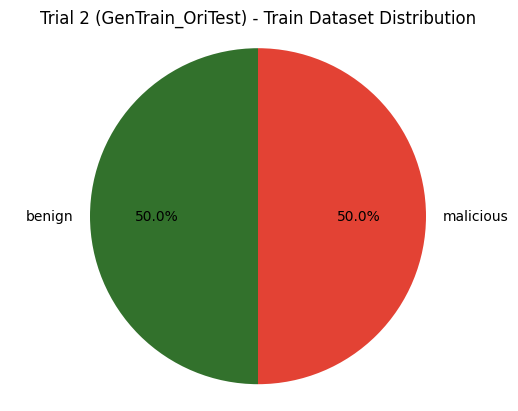

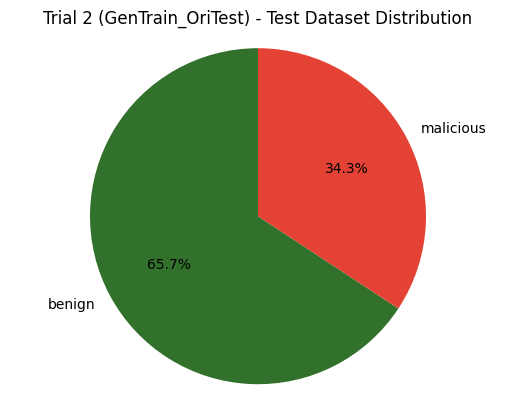

Training Random Forest on 40 batches


Batches: 100%|██████████| 40/40 [04:28<00:00,  6.72s/it]


Training Naive Bayes on 40 batches


Batches: 100%|██████████| 40/40 [03:39<00:00,  5.50s/it]


Training CNN on 40 batches


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

20350/20350 [==============================] - 32s 2ms/step


Batches:   2%|▎         | 1/40 [00:47<30:34, 47.04s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:   5%|▌         | 2/40 [01:27<27:20, 43.18s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:   8%|▊         | 3/40 [02:09<26:21, 42.75s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  10%|█         | 4/40 [02:52<25:33, 42.59s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  12%|█▎        | 5/40 [03:35<25:00, 42.87s/it]

20350/20350 [==============================] - 35s 2ms/step


Batches:  15%|█▌        | 6/40 [04:19<24:34, 43.36s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  18%|█▊        | 7/40 [05:03<23:51, 43.38s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  20%|██        | 8/40 [05:45<23:01, 43.18s/it]

20350/20350 [==============================] - 36s 2ms/step


Batches:  22%|██▎       | 9/40 [06:31<22:43, 43.99s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  25%|██▌       | 10/40 [07:11<21:19, 42.65s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  28%|██▊       | 11/40 [07:54<20:37, 42.66s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  30%|███       | 12/40 [08:40<20:29, 43.92s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  32%|███▎      | 13/40 [09:22<19:28, 43.26s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  35%|███▌      | 14/40 [10:05<18:38, 43.01s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  38%|███▊      | 15/40 [10:48<18:01, 43.28s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  40%|████      | 16/40 [11:32<17:24, 43.50s/it]

20350/20350 [==============================] - 36s 2ms/step


Batches:  42%|████▎     | 17/40 [12:19<16:58, 44.30s/it]

20350/20350 [==============================] - 35s 2ms/step


Batches:  45%|████▌     | 18/40 [13:03<16:15, 44.35s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  48%|████▊     | 19/40 [13:47<15:27, 44.15s/it]

20350/20350 [==============================] - 35s 2ms/step


Batches:  50%|█████     | 20/40 [14:35<15:05, 45.29s/it]

20350/20350 [==============================] - 32s 2ms/step


Batches:  52%|█████▎    | 21/40 [15:15<13:54, 43.94s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  55%|█████▌    | 22/40 [15:54<12:41, 42.30s/it]

20350/20350 [==============================] - 35s 2ms/step


Batches:  57%|█████▊    | 23/40 [16:41<12:22, 43.66s/it]

20350/20350 [==============================] - 34s 2ms/step


Batches:  60%|██████    | 24/40 [17:25<11:42, 43.94s/it]

20350/20350 [==============================] - 33s 2ms/step


Batches:  62%|██████▎   | 25/40 [18:07<10:49, 43.32s/it]

20350/20350 [==============================] - 32s 2ms/step


Batches:  65%|██████▌   | 26/40 [18:51<10:06, 43.33s/it]

20350/20350 [==============================] - 35s 2ms/step


Batches:  68%|██████▊   | 27/40 [19:34<09:23, 43.37s/it]

20350/20350 [==============================] - 31s 2ms/step


Batches:  70%|███████   | 28/40 [20:14<08:26, 42.25s/it]

20350/20350 [==============================] - 31s 2ms/step


Batches:  72%|███████▎  | 29/40 [20:53<07:35, 41.42s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  75%|███████▌  | 30/40 [21:32<06:46, 40.64s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  78%|███████▊  | 31/40 [22:11<06:00, 40.07s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  80%|████████  | 32/40 [22:49<05:16, 39.62s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  82%|████████▎ | 33/40 [23:30<04:39, 39.95s/it]

20350/20350 [==============================] - 32s 2ms/step


Batches:  85%|████████▌ | 34/40 [24:10<04:00, 40.09s/it]

20350/20350 [==============================] - 31s 2ms/step


Batches:  88%|████████▊ | 35/40 [24:50<03:19, 39.99s/it]

20350/20350 [==============================] - 31s 2ms/step


Batches:  90%|█████████ | 36/40 [25:29<02:38, 39.71s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  92%|█████████▎| 37/40 [26:08<01:57, 39.32s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  95%|█████████▌| 38/40 [26:46<01:18, 39.12s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches:  98%|█████████▊| 39/40 [27:25<00:38, 38.93s/it]

20350/20350 [==============================] - 30s 1ms/step


Batches: 100%|██████████| 40/40 [28:03<00:00, 42.09s/it]


20350/20350 [==============================] - 30s 1ms/step


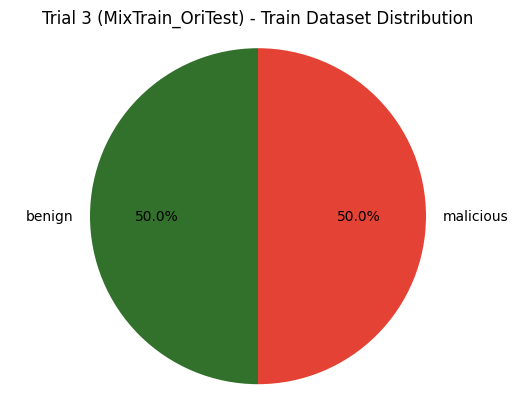

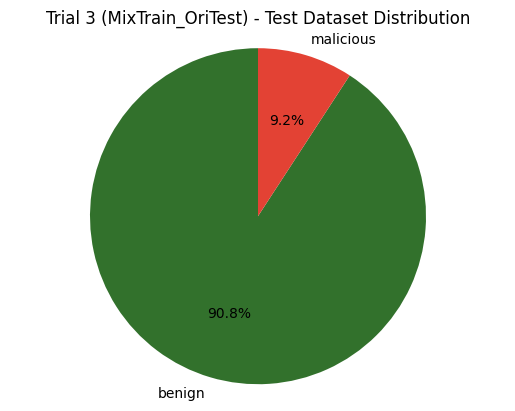

Training Random Forest on 80 batches


Batches: 100%|██████████| 80/80 [06:12<00:00,  4.65s/it]


Training Naive Bayes on 80 batches


Batches: 100%|██████████| 80/80 [03:05<00:00,  2.32s/it]


Training CNN on 80 batches


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

7850/7850 [==============================] - 11s 1ms/step


Batches:   1%|▏         | 1/80 [00:16<21:43, 16.50s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   2%|▎         | 2/80 [00:31<20:35, 15.84s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   4%|▍         | 3/80 [00:47<20:12, 15.75s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   5%|▌         | 4/80 [01:03<19:51, 15.67s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   6%|▋         | 5/80 [01:18<19:34, 15.66s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   8%|▊         | 6/80 [01:34<19:14, 15.60s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:   9%|▉         | 7/80 [01:49<18:58, 15.60s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  10%|█         | 8/80 [02:05<18:43, 15.60s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  11%|█▏        | 9/80 [02:20<18:26, 15.58s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  12%|█▎        | 10/80 [02:36<18:13, 15.63s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  14%|█▍        | 11/80 [02:52<17:58, 15.63s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  15%|█▌        | 12/80 [03:08<17:47, 15.69s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  16%|█▋        | 13/80 [03:23<17:30, 15.68s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  18%|█▊        | 14/80 [03:39<17:18, 15.74s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  19%|█▉        | 15/80 [03:55<17:04, 15.76s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  20%|██        | 16/80 [04:11<16:51, 15.80s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  21%|██▏       | 17/80 [04:27<16:37, 15.83s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  22%|██▎       | 18/80 [04:43<16:20, 15.82s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  24%|██▍       | 19/80 [04:59<16:07, 15.86s/it]

7850/7850 [==============================] - 13s 2ms/step


Batches:  25%|██▌       | 20/80 [05:15<16:07, 16.13s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  26%|██▋       | 21/80 [05:31<15:44, 16.01s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  28%|██▊       | 22/80 [05:46<15:15, 15.79s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  29%|██▉       | 23/80 [06:02<14:56, 15.73s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  30%|███       | 24/80 [06:18<14:39, 15.71s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  31%|███▏      | 25/80 [06:33<14:25, 15.73s/it]

7850/7850 [==============================] - 11s 1ms/step


Batches:  32%|███▎      | 26/80 [06:49<14:04, 15.64s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  34%|███▍      | 27/80 [07:05<13:53, 15.73s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  35%|███▌      | 28/80 [07:20<13:38, 15.74s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  36%|███▋      | 29/80 [07:37<13:28, 15.85s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  38%|███▊      | 30/80 [07:52<13:10, 15.82s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  39%|███▉      | 31/80 [08:08<12:54, 15.80s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  40%|████      | 32/80 [08:24<12:40, 15.85s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  41%|████▏     | 33/80 [08:40<12:25, 15.85s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  42%|████▎     | 34/80 [08:56<12:05, 15.78s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  44%|████▍     | 35/80 [09:11<11:50, 15.80s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  45%|████▌     | 36/80 [09:27<11:35, 15.81s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  46%|████▋     | 37/80 [09:43<11:18, 15.78s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  48%|████▊     | 38/80 [09:59<11:04, 15.81s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  49%|████▉     | 39/80 [10:15<10:50, 15.86s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  50%|█████     | 40/80 [10:30<10:32, 15.82s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  51%|█████▏    | 41/80 [10:46<10:17, 15.82s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  52%|█████▎    | 42/80 [11:02<09:59, 15.77s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  54%|█████▍    | 43/80 [11:18<09:44, 15.78s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  55%|█████▌    | 44/80 [11:34<09:28, 15.79s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  56%|█████▋    | 45/80 [11:49<09:12, 15.79s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  57%|█████▊    | 46/80 [12:05<08:57, 15.79s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  59%|█████▉    | 47/80 [12:21<08:39, 15.74s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  60%|██████    | 48/80 [12:36<08:22, 15.71s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  61%|██████▏   | 49/80 [12:52<08:08, 15.76s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  62%|██████▎   | 50/80 [13:08<07:51, 15.72s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  64%|██████▍   | 51/80 [13:24<07:34, 15.69s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  65%|██████▌   | 52/80 [13:39<07:20, 15.74s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  66%|██████▋   | 53/80 [13:55<07:07, 15.83s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  68%|██████▊   | 54/80 [14:11<06:51, 15.83s/it]

7850/7850 [==============================] - 13s 2ms/step


Batches:  69%|██████▉   | 55/80 [14:30<06:57, 16.68s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  70%|███████   | 56/80 [14:47<06:39, 16.65s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  71%|███████▏  | 57/80 [15:02<06:18, 16.44s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  72%|███████▎  | 58/80 [15:19<06:04, 16.55s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  74%|███████▍  | 59/80 [15:35<05:41, 16.26s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  75%|███████▌  | 60/80 [15:50<05:21, 16.06s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  76%|███████▋  | 61/80 [16:06<05:04, 16.01s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  78%|███████▊  | 62/80 [16:22<04:45, 15.83s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  79%|███████▉  | 63/80 [16:38<04:29, 15.83s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  80%|████████  | 64/80 [16:53<04:12, 15.77s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  81%|████████▏ | 65/80 [17:09<03:56, 15.79s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  82%|████████▎ | 66/80 [17:25<03:40, 15.77s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  84%|████████▍ | 67/80 [17:41<03:25, 15.78s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  85%|████████▌ | 68/80 [17:57<03:10, 15.85s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  86%|████████▋ | 69/80 [18:13<02:55, 16.00s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  88%|████████▊ | 70/80 [18:29<02:41, 16.16s/it]

7850/7850 [==============================] - 13s 2ms/step


Batches:  89%|████████▉ | 71/80 [18:46<02:27, 16.35s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  90%|█████████ | 72/80 [19:02<02:10, 16.30s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  91%|█████████▏| 73/80 [19:19<01:54, 16.29s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  92%|█████████▎| 74/80 [19:35<01:36, 16.14s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  94%|█████████▍| 75/80 [19:51<01:20, 16.13s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  95%|█████████▌| 76/80 [20:07<01:04, 16.10s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  96%|█████████▋| 77/80 [20:23<00:48, 16.09s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches:  98%|█████████▊| 78/80 [20:39<00:32, 16.00s/it]

7850/7850 [==============================] - 12s 1ms/step


Batches:  99%|█████████▉| 79/80 [20:54<00:15, 15.94s/it]

7850/7850 [==============================] - 12s 2ms/step


Batches: 100%|██████████| 80/80 [21:10<00:00, 15.88s/it]

   1/7850 [..............................] - ETA: 4:12

7850/7850 [==============================] - 12s 2ms/step


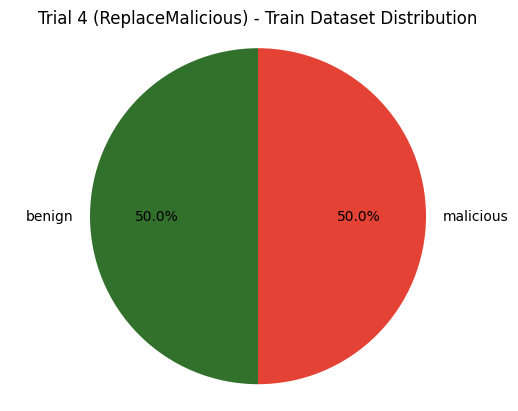

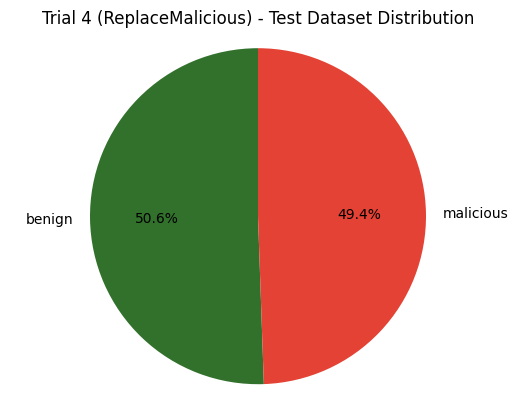

Training Random Forest on 40 batches


Batches: 100%|██████████| 40/40 [03:06<00:00,  4.65s/it]


Training Naive Bayes on 40 batches


Batches: 100%|██████████| 40/40 [02:41<00:00,  4.05s/it]


Training CNN on 40 batches


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

14100/14100 [==============================] - 20s 1ms/step


Batches:   2%|▎         | 1/40 [00:29<19:04, 29.35s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:   5%|▌         | 2/40 [00:57<18:05, 28.56s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:   8%|▊         | 3/40 [01:24<17:14, 27.96s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  10%|█         | 4/40 [01:51<16:25, 27.39s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  12%|█▎        | 5/40 [02:17<15:48, 27.11s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  15%|█▌        | 6/40 [02:44<15:14, 26.89s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  18%|█▊        | 7/40 [03:11<14:49, 26.95s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  20%|██        | 8/40 [03:37<14:18, 26.82s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  22%|██▎       | 9/40 [04:04<13:49, 26.75s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  25%|██▌       | 10/40 [04:31<13:23, 26.80s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  28%|██▊       | 11/40 [04:58<12:58, 26.86s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  30%|███       | 12/40 [05:25<12:39, 27.11s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  32%|███▎      | 13/40 [05:52<12:10, 27.05s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  35%|███▌      | 14/40 [06:19<11:41, 26.97s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  38%|███▊      | 15/40 [06:46<11:10, 26.80s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  40%|████      | 16/40 [07:12<10:43, 26.81s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  42%|████▎     | 17/40 [07:39<10:16, 26.80s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  45%|████▌     | 18/40 [08:07<09:53, 26.97s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  48%|████▊     | 19/40 [08:33<09:24, 26.90s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  50%|█████     | 20/40 [09:00<08:55, 26.75s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  52%|█████▎    | 21/40 [09:26<08:26, 26.67s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  55%|█████▌    | 22/40 [09:53<07:59, 26.66s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  57%|█████▊    | 23/40 [10:20<07:33, 26.68s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  60%|██████    | 24/40 [10:47<07:08, 26.81s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  62%|██████▎   | 25/40 [11:13<06:42, 26.81s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  65%|██████▌   | 26/40 [11:40<06:14, 26.74s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  68%|██████▊   | 27/40 [12:07<05:47, 26.75s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  70%|███████   | 28/40 [12:34<05:20, 26.73s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:  72%|███████▎  | 29/40 [13:01<04:56, 26.93s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:  75%|███████▌  | 30/40 [13:30<04:34, 27.49s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  78%|███████▊  | 31/40 [13:56<04:04, 27.17s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  80%|████████  | 32/40 [14:23<03:35, 26.99s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  82%|████████▎ | 33/40 [14:50<03:08, 27.00s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  85%|████████▌ | 34/40 [15:17<02:42, 27.08s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  88%|████████▊ | 35/40 [15:44<02:14, 26.92s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  90%|█████████ | 36/40 [16:10<01:47, 26.88s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  92%|█████████▎| 37/40 [16:37<01:20, 26.95s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  95%|█████████▌| 38/40 [17:04<00:53, 26.88s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  98%|█████████▊| 39/40 [17:31<00:26, 26.99s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches: 100%|██████████| 40/40 [17:58<00:00, 26.96s/it]

    1/14100 [..............................] - ETA: 7:07

14100/14100 [==============================] - 21s 1ms/step


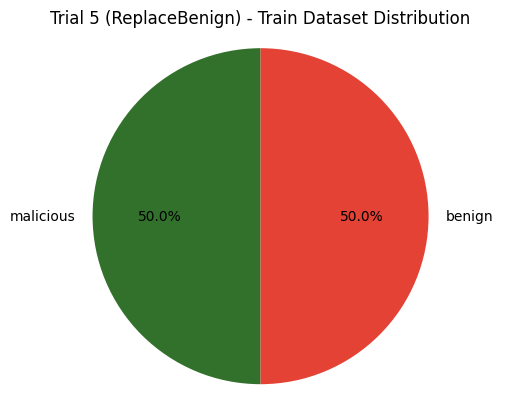

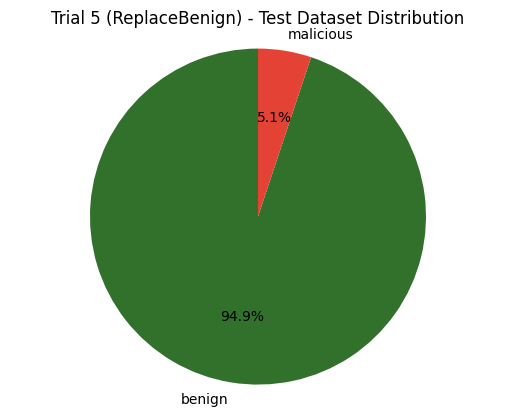

Training Random Forest on 40 batches


Batches: 100%|██████████| 40/40 [03:25<00:00,  5.13s/it]


Training Naive Bayes on 40 batches


Batches: 100%|██████████| 40/40 [02:30<00:00,  3.75s/it]


Training CNN on 40 batches


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

14100/14100 [==============================] - 20s 1ms/step


Batches:   2%|▎         | 1/40 [00:26<17:26, 26.83s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:   5%|▌         | 2/40 [00:52<16:40, 26.32s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:   8%|▊         | 3/40 [01:18<16:11, 26.26s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  10%|█         | 4/40 [01:45<15:44, 26.23s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  12%|█▎        | 5/40 [02:11<15:22, 26.37s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  15%|█▌        | 6/40 [02:38<14:56, 26.37s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  18%|█▊        | 7/40 [03:04<14:25, 26.24s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  20%|██        | 8/40 [03:29<13:53, 26.06s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  22%|██▎       | 9/40 [03:56<13:29, 26.13s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  25%|██▌       | 10/40 [04:23<13:11, 26.38s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:  28%|██▊       | 11/40 [04:49<12:50, 26.56s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  30%|███       | 12/40 [05:17<12:28, 26.74s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  32%|███▎      | 13/40 [05:44<12:03, 26.79s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  35%|███▌      | 14/40 [06:10<11:33, 26.69s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  38%|███▊      | 15/40 [06:36<10:59, 26.37s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  40%|████      | 16/40 [07:02<10:29, 26.23s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  42%|████▎     | 17/40 [07:28<10:05, 26.32s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  45%|████▌     | 18/40 [07:54<09:34, 26.11s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  48%|████▊     | 19/40 [08:20<09:07, 26.07s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  50%|█████     | 20/40 [08:45<08:39, 25.99s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  52%|█████▎    | 21/40 [09:12<08:14, 26.00s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  55%|█████▌    | 22/40 [09:37<07:47, 25.97s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:  57%|█████▊    | 23/40 [10:05<07:30, 26.53s/it]

14100/14100 [==============================] - 21s 2ms/step


Batches:  60%|██████    | 24/40 [10:33<07:09, 26.87s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  62%|██████▎   | 25/40 [11:00<06:44, 26.96s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  65%|██████▌   | 26/40 [11:27<06:19, 27.08s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  68%|██████▊   | 27/40 [11:56<05:56, 27.45s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  70%|███████   | 28/40 [12:22<05:26, 27.23s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  72%|███████▎  | 29/40 [12:49<04:57, 27.01s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  75%|███████▌  | 30/40 [13:15<04:28, 26.83s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  78%|███████▊  | 31/40 [13:42<03:59, 26.66s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  80%|████████  | 32/40 [14:08<03:31, 26.50s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  82%|████████▎ | 33/40 [14:34<03:05, 26.52s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  85%|████████▌ | 34/40 [15:01<02:38, 26.48s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  88%|████████▊ | 35/40 [15:27<02:12, 26.47s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  90%|█████████ | 36/40 [15:54<01:46, 26.61s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  92%|█████████▎| 37/40 [16:21<01:20, 26.72s/it]

14100/14100 [==============================] - 20s 1ms/step


Batches:  95%|█████████▌| 38/40 [16:48<00:53, 26.72s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches:  98%|█████████▊| 39/40 [17:15<00:26, 26.77s/it]

14100/14100 [==============================] - 21s 1ms/step


Batches: 100%|██████████| 40/40 [17:42<00:00, 26.57s/it]


14100/14100 [==============================] - 21s 2ms/step


In [101]:
trial_performances = {}

for name, train_filepath, test_filepath in trials:
    trial_performances[name] = {}
    
    train_df = load_dataset(train_filepath)
    test_df = load_dataset(test_filepath)
    
    # Plot distribution of train and test datasets
    plot_distribution(train_df, f"{name} - Train Dataset Distribution")
    plot_distribution(test_df, f"{name} - Test Dataset Distribution")
    
    # Tokenize URLs
    train_tokenized_urls = tokenize_urls(train_df["url"].tolist())
    test_tokenized_urls = tokenize_urls(test_df["url"].tolist())

    # Train Word2Vec model
    word2vec_model = train_word2vec_model(train_tokenized_urls + test_tokenized_urls)

    # Get URL embeddings
    train_url_embeddings = get_url_embeddings(train_tokenized_urls, word2vec_model)
    test_url_embeddings = get_url_embeddings(test_tokenized_urls, word2vec_model)
    
    y_train = train_df["target"].tolist()
    y_test = test_df["target"].tolist() 
    
    trial_performances[name] = run_trial(train_url_embeddings, y_train, test_url_embeddings, y_test)
    

In [107]:
# Save the trial performances
output_dir = "./outputs"
os.makedirs(output_dir, exist_ok=True)
json.dump(trial_performances, open(f"{output_dir}/trial_performances.json", "w"), indent=4)

In [114]:
for model_name in ["Random Forest", "Naive Bayes", "CNN"]:
    # Plot line graph per model with each trial plotted together
    plt.figure(figsize=(10, 6))
    for trial_name, trials_data in trial_performances.items():
        for name, model_data in trials_data.items():
            if name == model_name:
                accuracies = model_data["accuracy_list"][:40]
                plt.plot(range(1, len(accuracies) + 1), accuracies, label=trial_name)
    plt.xlabel("Batches (10,000 instances per batch)")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracies across trials for {model_name}")
    plt.legend()
    # plt.show()

    # Save the figure to the "plots" directory
    output_path = os.path.join(output_dir, f"{model_name}_accuracies_plot.png")
    plt.savefig(output_path)
    plt.close()


In [115]:
data = {
    "Class": ["RandomForestClassifier", "GaussianNB", "CNN"],
}

for trial_name, trial_data in trial_performances.items():
    data[trial_name] = []
    for model_name, model_data in trial_data.items():
        data[trial_name].append(max(model_data["accuracy_list"]))
    
print(data)

df = pd.DataFrame(data)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bar chart without stacking
width = 0.15  # the width of the bars
ind = np.arange(len(df['Class']))  # the label locations
margin = -.3
trial_names = list(trial_performances.keys())

for i, trial_name in enumerate(trial_names):
    ax.bar(ind + margin, df[trial_name], width, label=trial_name)
    margin += width 

# Customize the plot
ax.set_title('Accuracy by Model and Trial')
ax.set_ylabel('Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(df['Class'])

# Set y-axis lower limit
ax.set_ylim(0.6)

ax.legend()

output_path = os.path.join(output_dir, "accuracy_by_model_and_trial_plot.png")
plt.savefig(output_path)
plt.close()

{'Class': ['RandomForestClassifier', 'GaussianNB', 'CNN'], 'Trial 1 (Baseline)': [0.9580637841323932, 0.8785943763908739, 0.8353603433244026], 'Trial 2 (GenTrain_OriTest)': [0.8366500765520408, 0.8154673513608143, 0.7739848984399355], 'Trial 3 (MixTrain_OriTest)': [0.9612963840264978, 0.8890644967375424, 0.8898726467110685], 'Trial 4 (ReplaceMalicious)': [0.7675950983064822, 0.7794415225481005, 0.6735373710911787], 'Trial 5 (ReplaceBenign)': [0.7457639890866617, 0.7551369597354557, 0.9488287665312473]}


In [111]:
# Print each model's confusion matrix
for trial_name, trial_data in trial_performances.items():
    for model_name, model_data in trial_data.items():
        report = model_data["report"]
        print(f"Classification Report for {model_name} in {trial_name}:\n")
        print(report)

Classification Report for Random Forest in Trial 1 (Baseline):

              precision    recall  f1-score   support

      benign     0.9742    0.9796    0.9769    228103
   malicious     0.7868    0.7436    0.7646     23088

    accuracy                         0.9579    251191
   macro avg     0.8805    0.8616    0.8708    251191
weighted avg     0.9570    0.9579    0.9574    251191

Classification Report for Naive Bayes in Trial 1 (Baseline):

              precision    recall  f1-score   support

      benign     0.9655    0.8981    0.9305    228103
   malicious     0.4040    0.6826    0.5076     23088

    accuracy                         0.8783    251191
   macro avg     0.6847    0.7904    0.7191    251191
weighted avg     0.9139    0.8783    0.8917    251191

Classification Report for CNN in Trial 1 (Baseline):

              precision    recall  f1-score   support

           0     0.9625    0.8023    0.8751    228103
           1     0.2612    0.6908    0.3791     23088

  